# Implementing time-varying covariates

In this notebook, we analyse a simulated dataset with time-varying covariates and survival outcomes. `TorchSurv` is used to train a model that predicts relative risk of subjects based on covariates observed over time. We will attempt to thoroughly explain the necessary elements to understand our implementation, but for a detailed read on time-varying survival models refer to Chapter 6 of [Dynamic Regression Models for Survival Data](https://link.springer.com/book/10.1007/0-387-33960-4). For a more brief explanation, please refer to these [slides](https://ms.uky.edu/~mai/sta635/Cox%20model.pdf). Below is a summary of the necessary information.

### Future project ideas:
Future projects can take on various themes: testing edge cases of this implementation, improving the code to become more robust to different data types, include weibull distribution and compare this approate.
Testing edge cases:
- use the simulated data and change different parameters to see how it affects performance, this can help guide appropriate use
- design slightly different simulations known for being difficult or easy in specific scenarios
- use a dataset with known properties

Improving code to be more robust:
- generalising the loss functions and overall defining the formatting required or it to work, generalise for different time scales etc.
- extend the method to deal with multiple types of covariates in one loss function or a combination of multiple losses. This can extend to multiple time-varyin covariates and mixing time-invarint and varying ones.

Weibull:
- Extent the cox loss function to also include the Weibull distribution, this is described for both the log-likelihood and the simulation

Comparison
- One could compare this approach to other loss functions or statistical model to get an idea of what it brings as a benefit and a challenge. Note this comparison can be done via simulation or some dataset.


## Partial log likelihood for time-varying covariates

### Context and statistical set-up

Let $i$ e the index for some subject $i$ with a failute time denoted as $\tau^*_i$ and $C$ be the censoring time. For the moment $C$ remains constant but there are extensions that allow for $C$ to vary over $i$. Let $\tau_i = min(\tau^*_i, C)$. We use $\delta_i$ to denote whether $\tau^*_i$ was observed. 

We will use $Z(t)$ to denote the value of of covariate $Z$ and time $t$. 
We use $Z(t)$ to denote the value of Z at time $t$ and $\overline{Z}(t)$ to denote the set of covariates from the beggining up to time $t$: $ \overline{Z}(t) = \{ Z(s): 0 \leq s \leq t\}$.
Let $t_k$ for $k \in \{1, \dots, K\} denote the time points at which the covariates are observed. For the moment, we assume that all subjects have been observed on the same time grid. $R_k$ is the set of individuals who are at risk at $t_k$. 

The conditional hazard function of $T$ given $\overline{Z}(t)$ is defined as
$$ \lambda(T|\overline{Z}(t)) = Pr(T \in [t, t+ dt)|T \geq t, \overline{Z}(t)), $$
in other words, it is the probability that an event will occur in the next time instance if we have observed covariates up to time $t$ and that a subject has not yet experienced an event.

The typical cox proportional hazards model with constant covariates $Z$ assumes a constant hazard ratio: $\lambda(T|Z)= \lambda_0(t) exp(\beta Z)$, where $\beta$ in an unknown set of regression parameters and $\lambda_0(t)$ is an unspecified baseline hazard function. In this case $\frac{\lambda(T|Z)}{\lambda_0(t)} = exp(\beta Z) $. The cumlative hazard ia defined as $\Lambda(t) = \int_0^t \lambda(s)ds$. 

In a time varying cox model, the hazard ratio is now dependant on time:
$$ \frac{\lambda(t|Z)}{\lambda_0(t)} = exp(\beta Z(t)) $$ 
and the proportinal hazard model specifies:
$$ \lambda(t|Z) = \lambda_0(t)exp(\beta Z(t)) $$

Let $i_j$ denote the label or identity of the individual who fails at time $\tau_j$, including the value of their time-varying covariate
during their time in the study $\{ Z_{i_j}(t): t \in [0, \tau_j] \}$. The partial likelihood is:
$$ L (\beta) = \prod_j \Big (\frac{\lambda(\tau_j: Z_i(\tau_j)))}{\sum_{l \in R_i} \lambda(\tau_j: Z_l(\tau_j)))} \Big),$$
in terms of the model form:
$$ L (\beta) = \prod_j \Big (\frac{\exp(\beta Z_i(\tau_j))}{\sum_{j \in R_i} \exp(\beta Z_i(\tau_j))} \Big).$$

Taking the log on both sides, we get the partial log-likelihood:
$$ \log L (\beta) = \sum_j \Big (\beta Z_i(\tau_j)) - \log [\sum_{j \in R_i} \exp(\beta Z_i(\tau_j))]\Big ). $$


### Extension to neural networks

Consider a more genera form, where we have the cox proportional hazards model:
$$\lambda(T|\overline{Z}(t))= \lambda_0(t) \theta(Z(t))$$

Additionally, consider some network that maps the input covariates $Z(t)$ to the log relative hazards: $\log \theta(Z(t))$.

The partial likelihood with repsect to $\theta(Z(\tau_j))$ is written as:
$$ \log L(\theta) = \sum_j \Big( \log \theta(Z_i(\tau_j)) - \log [\sum_{j \in R_i} \theta (Z_i(\tau_j))] \Big).$$
It onlu considers the covariate values at the time of event or censoring denoted as $\tau_j$, all prior covariates are not considered.

As the output of the network is set to be $\log \theta(Z(t))$, the code is written to account for this, to show this explicitly, set $\phi(Z(t)) = \log \theta(Z(t))$ and write the log likelihood in terms oh $phi$:

$$ \log L(\theta) = \sum_j \Big( \phi(Z_i(\tau_j)) - \log [\sum_{j \in R_i} \exp \phi(Z_i(\tau_j))] \Big).$$


### Dependencies

To run this notebook, dependencies must be installed. the recommended method is to use our developpment conda environment (**preffered**). Instruction can be found [here](https://opensource.nibr.com/torchsurv/devnotes.html#set-up-a-development-environment-via-conda) to install all optional dependancies. The other method is to install only required packages using the command line below:

In [1]:
# Install only required packages (optional)
# %pip install lifelines
# %pip install matplotlib
# %pip install sklearn
# %pip install pandas

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Our package
#from torchsurv.loss.time_varying import neg_partial_log_likelihood2

# PyTorch boilerplate - see https://github.com/Novartis/torchsurv/blob/main/docs/notebooks/helpers_introduction.py
from helpers_introduction import Custom_dataset, plot_losses

## Simulating realistic data

A good approach for simulating data is described in detail by [Ngwa et al 2020](https://pmc.ncbi.nlm.nih.gov/articles/PMC7731987/). If this is not yet implemented, it would be a good way of starting to ensure that both methods work as expected. There are tow parts in simulating such a dataset. First, simulating the longitudina lobservational data and then the survival data. Below we describe methodologies for both.

### Longitudinal data (covariates)

We use $i \in \{1, \dots, n\}$ to index subjects and $j \in \{1, \dots, m_i\}$ to index time points where $m_i$ is the final time point for subject $i$.
We simulate covariates independantly:
- age at baseline $Age_i \sim N(35,5)$
- sex $\sim Bernoulli(p=0.54)$

Generate expected longitudinal trajectories $\varphi_{\beta}(t_{ij})$:

$$ \varphi_{\beta}(t_{ij}) = b_{i1} + b_{i2} \cdot t_{ij} + \alpha Age_i, $$

where $b_{i1}, b_{i2}$ are random effects

We will generate $b_{i1}, b_{i2}$ from multivariate normal distribution with a covariance matrix $G = [[0.29, -0.00465],[-0.00465, 0.000320]]$. Sample from this multivariate normal distribution (with mean zero) to get the random intercept and slope.

The observed longitudinal measures measures $Y_{ij}(t_{ij})$ from a multivariate normal distribution with mean $ \varphi_{\beta}(t_{ij})$ and variance $V$:

$$ V = Z_i GZ_i ^T + R_i, \text{ where }Z_i = [[1,1,1,1,1,1]^T, [0,5,10,15,20,25]^T]$$

and $R_i = diag(\sigma^2)$ and $\sigma^2$ is set to $0.1161$.

Note: Compared to the paper, we slightly adjust steps 3 and 4 from the simulation algorithm section (6.1) to avoid fitting a random effects model which adds more complexity in terms of data formatting. 

In [4]:
import torch.distributions as dist

# Set random seed for reproducibility
torch.manual_seed(123)

n = 100  # Number of subjects
T = torch.tensor(6)    # Number of time points
time_vec = torch.tensor([0, 1, 2, 3, 4, 5])

# Simulation parameters
age_mean = 35
age_std = 5
sex_prob = 0.54
G = torch.tensor([[0.29, -0.00465],[-0.00465, 0.000320]])
Z = torch.tensor([[1, 1, 1, 1, 1, 1], time_vec], dtype=torch.float32).T
sigma = torch.tensor([0.1161])
alpha = 1

# Simulate age at baseline
age_dist = dist.Normal(age_mean, age_std)
age = age_dist.sample((n,))

# Simulate sex
sex_dist = dist.Bernoulli(probs=sex_prob)
sex = sex_dist.sample((n,))

# Simulate random effects
random_effects_dist = dist.MultivariateNormal(torch.zeros(2), G)
random_effects = random_effects_dist.sample((n,))

# sample random error
error_sample = dist.Normal(0, sigma).sample((n,))

# Generate expected longitudinal trajectories
# quite frakly this is useless now - it was based on my bad understanding of the algorithm
trajectories = random_effects[:, 0].unsqueeze(1) + random_effects[:, 1].unsqueeze(1) * Z[:,1] + alpha * age.unsqueeze(1) + error_sample

print(trajectories[1:5, :])

tensor([[34.2016, 34.2186, 34.2356, 34.2526, 34.2696, 34.2866],
        [33.4380, 33.4308, 33.4235, 33.4163, 33.4091, 33.4018],
        [31.5581, 31.5564, 31.5548, 31.5531, 31.5515, 31.5498],
        [35.7813, 35.7953, 35.8093, 35.8233, 35.8373, 35.8513]])


In [5]:
## ANOTHER WAY OF GENERATING DATA

# # Simulate observed longitudinal measures
# R = torch.diag_embed(sigma.repeat(T))
# V = torch.matmul(torch.matmul(Z, G), Z.T) + R

# #get a mean trajectory
# b1 = torch.tensor([4.250])
# b2 = torch.tensor([0.250])
# mean_trajectory =  b1.item() + b2.item() * Z[:,1] + alpha * age_mean

# #define the distribution to sample the trajectories from
# observed_data_dist = dist.MultivariateNormal(trajectories, V)

# #sample from the distribution to get an n x T matrix of observations/covariates
# observed_data = observed_data_dist.sample((1,)).squeeze()

# print(observed_data[1:5, :])

### Survival data (outcomes)

here I will describe how to get the survival and censoring for all the subjects from above. then I will code it up in python.

Specify (varying) values for the parameter estimates for $Age$, $sex$ and the link parameter $\gamma$, which measures the strength of the association between the longitudinal measures $Y_{ij}(t_{ij})$ and the time-to-event $\tau_j$.

Let $Q \sim Unif(0,1)$ be a random variable that determines the hazard of a subject. Then using the time varying cox model it can be expressd as:

$$ Q(t;X,Y) = \exp[-H_0(t)\cdot \exp(X^T\alpha + \gamma (b_{i1} + b_{i2} \cdot t))],$$
$X^T$ is a vector of tine-invariant covariates, $\alpha$ a vector of regression coefficients.

$H_o(t) = \lambda t$ and if $h_0(t)>0$ for all $t$, then $H_0$ can be inverted:
$$-\log(Q) = \lambda t \cdot \exp[X^T \alpha + \gamma (b_{i1} + b_{i2} \cdot t) ] $$
This expression can be rearranged to generate the times-to-event.

Generate the time-to-event $\tau_j$ using the following equations for the Cox Exponential model:
$$ t = \frac{1}{\gamma \cdot b_{i2}} W \Big( \frac{-\gamma(b_{i2}) \log(Q)}{\lambda \exp (X^T \alpha + \gamma(b_{i1}))} \Big). $$

Where $W$ is the Lambert W function (LWF) first proposed by [Corless et al. 1996](https://link.springer.com/article/10.1007/BF02124750) provide a history, theory and applications of the LWF. The LWF is the inverse of the function $f(p) = p \cdot \exp(p) $.

Generate the censoring variable $C \sim Unif⁡(25, 30)$ for censoring to occur later in study. From the survival and censoring times, we obtain the censoring indicator $\delta_i$ which is defined as 1 if $\tau_j < C_i$ and 0 otherwise.


In [6]:
#import lmbert W function

from scipy.special import lambertw

Note: pre-determined parameters such as $\alpha, \gamma, \lambda_0$ have a large effect on the event time outcomes, the values used here are:
- $\alpha_{age} = 0.05$,
- $\alpha_{sex} = -0.5$,
- $\gamma = 0.1$,
- $\lambda_0 = 0.05$


In [7]:
# Specify the values for parameters, generate the random variables and call on relevant variables defined previously

alpha = torch.tensor([0.05, -0.5])  # regression coefficient for time-invariant covariates
gamma = torch.tensor(0.3)  # association strength between longitudinal measures and time-to-event
lambda_0 = torch.tensor(0.1)  # baseline hazard rate

torch.manual_seed(456)

# Generate the random variables for hazard of a subject and censoring
Q = dist.Uniform(0, 1).sample((n,))  # Random variable for hazard (Q)
C = dist.Uniform(3,5.5).sample((n,))  # Random variable for censoring

# age and sex are the names of variables corresponding to those covariates
# create the X matrix of covariates
XX = torch.stack((age, sex), dim=1)

# get b1 and b2 from the random sample we made before
b1 = random_effects[:, 0]
b2 = random_effects[:, 1]

# Generate time to event T using the equation above
log_Q = torch.log(Q)
lambert_W_nominator = gamma*b2*log_Q
lambert_W_denominator = torch.exp(alpha@XX.T + gamma*b1)
# below should give a vector of length sample_size 
lambert_W = lambertw(-lambert_W_nominator/(lambda_0*lambert_W_denominator))
time_to_event = lambert_W/(gamma*b2)

#take the real part of the LBF, the complex part is =0
outcome_LWF = time_to_event.real
outcome_LWF = torch.floor(outcome_LWF)
outcome_LWF

# implement censoring with some level of intensity below
events = C<5
events

tensor([ True, False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True, False,
        False,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
        False,  True, False,  True, False,  True, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,  True])

A simpler method for generating the time-to-event where the covariate is assumed to have a more straightforward relation in time $Z(t) = kt$ for some $k>0$. This approach is sugested by [Peter C. Austin 2012](https://pmc.ncbi.nlm.nih.gov/articles/PMC3546387/pdf/sim0031-3946.pdf) and here 
$$ t = \frac{1}{\gamma k} \log \Big ( 1 + \frac{\gamma k (-log(u))}{\lambda \exp(\alpha X)}\Big). $$
The above equation has been adapted to remain consistent with the parameters defined before. In our case, $k$ could be replaced with $b_{i2}$ if $b_{i2}$ would be sampled such that it is strictly positive. In the above configuration that is not the case.



### Data Format

Here we create a single matrix of data that corresponds to one covariate being observed over time for some dataset.
The time series is padded with zeros so that each subject has the same legth vector, the vector contains their covariate $Z_i(t)$ up until failure time $\tau_j$ and then values beyond that are zero.

In general, prior to fitting a survival model or a network, one should consider ohw to handle missing data beforehand. This is most important for covariates that are missing at event time $\tau_j $. Data imputation methods can vary depending on the use case but some to consider are:
- use the most recent value (assumes step function),
- interpolate,
- impute based on some model.

## Training the RNN 

Below we will give an example set up of how to use the partial log likelihood in a loss function. We import the python file containg the loss and set up an RNN to work with our simulated data.

In [8]:
from importlib import reload
import loss_time_covariates

reload(loss_time_covariates)
log_likelihood = loss_time_covariates._partial_likelihood_time_cox
neg_loss_function = loss_time_covariates.neg_partial_time_log_likelihood

In [9]:
#from torchsurv.loss import time_covariates
#from torchsurv.metrics.cindex import ConcordanceIndex

# Parameters
input_size = 1
output_size = 1
num_layers = 2
seq_length = T
batch_size = n

# Create simple RNN model
rnn = torch.nn.RNN(input_size, output_size, num_layers)
inputs = torch.randn(seq_length, batch_size, input_size)
test = trajectories.T.unsqueeze(2)
print(test.shape)
print(inputs.shape)

#initializa hidden state
h0 = torch.randn(num_layers, batch_size, output_size)
print(h0.shape)
# Forward pass time series input
outputs, _ = rnn(test, h0)
print(outputs.shape)
# estimates = outputs[-1]  # Keep only last predictions, many to one approach
# print(estimates.size())  # torch.Size([8, 1])
# print(f"Estimate shape for {batch_size} samples = {estimates.size()}")  # Estimate shape for 8 samples = torch.Size([8, 1])


#loss = neg_loss_function(outputs, events, time)
# print(f"loss = {loss}, has gradient = {loss.requires_grad}")  # loss = 1.0389232635498047, has gradient = True

# cindex = ConcordanceIndex()
# print(f"c-index = {cindex(estimates, events, time)}")  # c-index = 0.20000000298023224

torch.Size([6, 100, 1])
torch.Size([6, 100, 1])
torch.Size([2, 100, 1])
torch.Size([6, 100, 1])


## Comparison to Lifelines package

Re-format the simulaiton data to fit a normal time-varying cox model in the lifelines package.

In [10]:
import pandas as pd

# as a reminder covars is the matrix of covariates where a row corresponds to a subject and a column corresponds to their observation at some time 
# the columns are padded so if a subject experiences an event, the remaining of the column is zero

# Generating example torch matrix
torch_matrix = trajectories
# Convert torch matrix to pandas dataframe

#set time to integer
max_time = max(time_vec.type(torch.int64))

vars = []
#times = []
start = []
stop = []
event = []
subjs = []
for i in range(n):
    subj_counter = 0
    for j in range(max_time):
        if torch_matrix[i,j] == 0:
            break
        else:
            vars.append(torch_matrix[i,j].item())
            #times.append(j)
            start.append(j-1)
            stop.append(j)
            event.append(False)
            subj_counter += 1
    subjs.extend([i] * subj_counter)
    if events[i]==True: event[-1]=True

df = pd.DataFrame({
    "subj": subjs,
    #"times": times,
    "start":start,
    "stop": stop,
    "events": event,
    "var": vars, 
})


Fitting a cox regression model using the lifelines package.


Iteration 1: norm_delta = 5.88e-02, step_size = 0.9500, log_lik = -324.39949, newton_decrement = 2.39e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.77e-03, step_size = 0.9500, log_lik = -324.16177, newton_decrement = 5.30e-04, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.38e-04, step_size = 0.9500, log_lik = -324.16124, newton_decrement = 1.32e-06, seconds_since_start = 0.0
Iteration 4: norm_delta = 7.26e-06, step_size = 1.0000, log_lik = -324.16124, newton_decrement = 3.30e-09, seconds_since_start = 0.0
Convergence completed after 4 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 500 periods, 100 subjects, 81 events>
         event col = 'events'
         penalizer = 0.1
number of subjects = 100
 number of periods = 500
  number of events = 81
partial log-likelihood = -324.16
  time fit was run = 2025-01-03 20:10:47 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
var       -0.01      0.99      0.02           -0.05            0.02                0.95                1.02

           cmp to     z    p  -log2(p)
covariate                             
var          0.00 -0.69 0.49      1.03
---
Partial AIC = 650.32
log-likelihood ratio test = 0.48 on 1 df
-log2(p) of ll-ratio test = 1.03

<Axes: xlabel='log(HR) (95% CI)'>

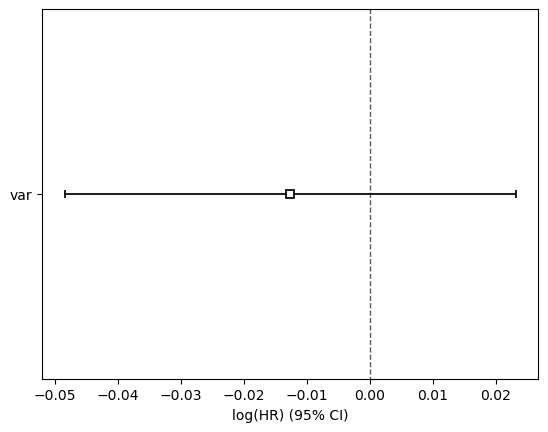

In [11]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(df, id_col="subj", event_col="events", start_col="start", stop_col="stop", show_progress=True)
ctv.print_summary()
ctv.plot()

## Testing it on the lifelines dataset

This is to demonstrate the method with a neural network, example inspired by the [lifelines example](https://lifelines.readthedocs.io/en/latest/Time%20varying%20survival%20regression.html#).

This is a classic dataset for survival regression with time varying covariates. The original dataset is from J Crowley and M Hu. 'Covariance analysis of heart transplant survival data', and this dataset is from R’s survival library.


In [12]:
import lifelines

df = lifelines.datasets.load_stanford_heart_transplants()
df.head(5)

,start,stop,event,age,year,surgery,transplant,id
0,0.0,50.0,1,-17.155373,0.123203,0,0,1
1,0.0,6.0,1,3.835729,0.254620,0,0,2
2,0.0,1.0,0,6.297057,0.265572,0,0,3
3,1.0,16.0,1,6.297057,0.265572,0,1,3
4,0.0,36.0,0,-7.737166,0.490075,0,0,4


The dataset contains the following:

- `start`: entry time,
- `stop`: exit time,
- `event`: status for this interval of time,
- `age`: subjetct's age -48 years,
- `year`: tyear of acceptance (in years after 1 Nov 1967)
- `surgery`: prior bypass surgery 1=yes
- `transplant`: received transplant 1=yes
- `id`: patient id

In [13]:
from lifelines.utils import to_long_format, add_covariate_to_timeline

base_df = pd.DataFrame([
  {'id': 1, 'duration': 10, 'event': True, 'var1': 0.1},
  {'id': 2, 'duration': 12, 'event': True, 'var1': 0.5}
])

base_df = to_long_format(base_df, duration_col="duration")

In [14]:
# Constant parameters accross models
# Detect available accelerator; Downgrade batch size if only CPU available
if any([torch.cuda.is_available(), torch.backends.mps.is_available()]):
    print("CUDA-enabled GPU/TPU is available.")
    BATCH_SIZE = 128  # batch size for training
else:
    print("No CUDA-enabled GPU found, using CPU.")
    BATCH_SIZE = 32  # batch size for training

EPOCHS = 100
LEARNING_RATE = 1e-2

CUDA-enabled GPU/TPU is available.


In [ ]:
df_train, df_test = train_test_split(df_onehot, test_size=0.3)
df_train, df_val = train_test_split(df_train, test_size=0.3)
print(
    f"(Sample size) Training:{len(df_train)} | Validation:{len(df_val)} |Testing:{len(df_test)}"
)

In [ ]:
# Dataloader
dataloader_train = DataLoader(
    Custom_dataset(df_train), batch_size=BATCH_SIZE, shuffle=True
)
dataloader_val = DataLoader(
    Custom_dataset(df_val), batch_size=len(df_val), shuffle=False
)
dataloader_test = DataLoader(
    Custom_dataset(df_test), batch_size=len(df_test), shuffle=False
)

In [ ]:
cox_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(num_features),  # Batch normalization
    torch.nn.Linear(num_features, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(64, 1),  # Estimating log hazards for Cox models
)

In [ ]:
# This is for testing the loss function
x_test, (test_event, test_time) = next(iter(dataloader_train))

log_hz = cox_model(x_test)

In [ ]:
print('x_test', x_test.shape)
print('events', test_event.shape)
print('times', test_time.shape)

time_sorted, idx = torch.sort(time)
log_hz_sorted = log_hz[idx]
event_sorted = event[idx]
time_unique = torch.unique(time_sorted)
print('')
print("time_sorted", time_sorted.shape)
print('log_hz_sorted', log_hz_sorted.shape)
print('event_sorted', event_sorted.shape)
print("time_unique", time_unique.shape)

print('-'*30)
cov_fake = torch.clone(x_test)
print('covariates', cov_fake.shape)
covariates_sorted = cov_fake[idx, :]
covariate_inner_product = torch.matmul(covariates_sorted, covariates_sorted.T)
print('cov_inner', covariate_inner_product.shape)
log_nominator_left = torch.matmul(log_hz_sorted.T, covariate_inner_product)
print('log_nom_left', log_nominator_left.shape)
bracket = torch.mul(log_hz_sorted, covariates_sorted)
print('bracket', bracket.shape)
log_nominator_right = torch.matmul(bracket, bracket.T)
print('log_nom_right', log_nominator_right.shape)
sum_nominator_right = log_nominator_right[0,].unsqueeze(0)
print('sum_nom', sum_nominator_right.shape)
log_denominator = torch.logcumsumexp(log_hz_sorted.flip(0), dim=0).flip(0).T
print('log_denom', log_denominator.shape)
last_bit = torch.div(log_nominator_left - sum_nominator_right, log_denominator)
print('last_bit', last_bit.shape)
last_bit


## RNN Example from Github

In [ ]:
import torch
from torchsurv.loss import cox
from torchsurv.metrics.cindex import ConcordanceIndex

# Parameters
input_size = 10
output_size = 1
num_layers = 2
seq_length = 5
batch_size = 8

# make random boolean events
events = torch.rand(batch_size) > 0.5
print(events)  # tensor([ True, False,  True,  True, False, False,  True, False])

# make random positive time to event
time = torch.rand(batch_size) * 100
print(time)  # tensor([32.8563, 38.3207, 24.6015, 72.2986, 19.9004, 65.2180, 73.2083, 21.2663])

# Create simple RNN model
rnn = torch.nn.RNN(input_size, output_size, num_layers)
inputs = torch.randn(seq_length, batch_size, input_size)
h0 = torch.randn(num_layers, batch_size, output_size)

# Forward pass time series input
outputs, _ = rnn(inputs, h0)
estimates = outputs[-1]  # Keep only last predictions, many to one approach
print(estimates.size())  # torch.Size([8, 1])
print(f"Estimate shape for {batch_size} samples = {estimates.size()}")  # Estimate shape for 8 samples = torch.Size([8, 1])


loss = cox.neg_partial_log_likelihood(estimates, events, time)
print(f"loss = {loss}, has gradient = {loss.requires_grad}")  # loss = 1.0389232635498047, has gradient = True

cindex = ConcordanceIndex()
print(f"c-index = {cindex(estimates, events, time)}")  # c-index = 0.20000000298023224